Dataset: https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop
# understanding information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
path = '2019-Oct.csv'
df = pd.read_csv(path)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


在导入时使用parse_date导入时间列为datetime格式，省略后面转换格式的步骤

In [140]:
#data = pd.read_csv(path, parse_dates=["event_time"])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ MB


In [4]:
df.event_type.value_counts()

view                1861933
cart                1232385
remove_from_cart     762110
purchase             245624
Name: event_type, dtype: int64

In [5]:
df.user_id.nunique()

399615

In [6]:
df.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4042523
brand            1659030
price                  0
user_id                0
user_session         637
dtype: int64

通过对数据的初步了解，本网站2019年10月共有410万笔用户行为记录数据，用户行为分为浏览、加入购物车、移除购物车、购买四种；本月共有近40万用户有对网站的访问行为。    
在缺失值方面，可以看到category_code, brand列有大量缺失数值，后续对产品类目进行分析时要注意，但考虑到category_id没有缺失值，对category_code的分析可以用id替代。

## 连接MySQL导入数据
以下为使用Python访问mysql的尝试，具体使用SQL调入数据的内容请见另一个jupyter notebook

In [143]:
import pymysql
conn = pymysql.connect(user="Janice", password="Janice_cao", database="e_com_cosmetics", charset="utf8")
query = "select * from events limit 1000"
df_read = pd.read_sql_query(query, conn)

"""
写入DataFrame数据使用：
data_writein.to_sql("table_name", conn, index=False)
"""
df_read.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


## transfer event_time to datetime
为后续按日期、小时处理数据，先将时间数据列转为datetime数据格式，并新增时分秒列

In [2]:
import re
#split date and time
df['time_zoneless'] = df.event_time.str[:-3]
df['date'] = df.time_zoneless.map(lambda x: re.compile(' ').split(x)[0])
df['time'] = df.time_zoneless.map(lambda x: re.compile(' ').split(x)[1])
df.time_zoneless = pd.to_datetime(df['time_zoneless'])
df.date = pd.to_datetime(df['date'])

In [3]:
df['hour'] = df.time_zoneless.dt.hour
df['minute'] = df.time_zoneless.dt.minute
df['second'] = df.time_zoneless.dt.second
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,time_zoneless,date,time,hour,minute,second
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00,2019-10-01,00:00:00,0,0,0
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03,2019-10-01,00:00:03,0,0,3
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07,2019-10-01,00:00:07,0,0,7
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07,2019-10-01,00:00:07,0,0,7
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15,2019-10-01,00:00:15,0,0,15


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 15 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     object        
 1   event_type     object        
 2   product_id     int64         
 3   category_id    int64         
 4   category_code  object        
 5   brand          object        
 6   price          float64       
 7   user_id        int64         
 8   user_session   object        
 9   time_zoneless  datetime64[ns]
 10  date           datetime64[ns]
 11  time           object        
 12  hour           int64         
 13  minute         int64         
 14  second         int64         
dtypes: datetime64[ns](2), float64(1), int64(6), object(6)
memory usage: 469.5+ MB


此处新增的无时区标记时间列、日期列为datetime格式；时分秒列为整数格式

# customer behavior analysis
## PV and UV
### daily for all events
Use group by to calculate the page view and unique visitor in each day:

In [4]:
pv_d = df.groupby('date').user_id.count().reset_index()
pv_d.rename(columns = {'user_id':'pv'}, inplace = True)
uv_d = df.groupby('date').user_id.nunique().reset_index()
uv_d.rename(columns = {'user_id':'uv'}, inplace = True)

In [146]:
pv_d.describe()

,pv
count,31.000000
mean,132331.709677
std,22342.858088
min,104300.000000
25%,117914.000000
50%,130030.000000
75%,136206.500000
max,201068.000000


In [147]:
uv_d.describe()

,uv
count,31.000000
mean,17952.903226
std,4490.876903
min,14533.000000
25%,15673.500000
50%,16950.000000
75%,17432.500000
max,33859.000000


To draw on the x axis, add one column 'day' and store the day from the date to this column:

In [148]:
pv_d['day'] = pv_d.date.dt.strftime("%d")
pv_d.head()
uv_d['day'] = uv_d.date.dt.strftime('%d')

In [149]:
pv_d_max = pv_d[pv_d.pv == pv_d.pv.max()]
pv_d_max

,date,pv,day
1,2019-10-02,201068,02


In [150]:
uv_d_max = uv_d[uv_d.uv == uv_d.uv.max()]
uv_d_max 

,date,uv,day
1,2019-10-02,33859,02


Draw the line plot for daily PV and daily UV:

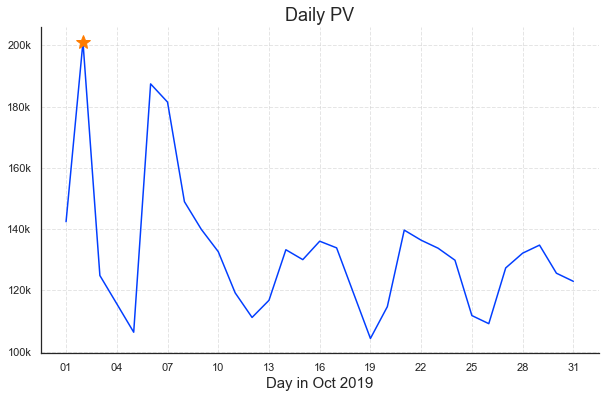

In [151]:
xlabel = range(1,32,2)
fig = plt.figure(figsize = (10,6))
sns.set(style = 'white', palette = 'bright')
ax = fig.add_subplot()
plt.plot(pv_d.day, pv_d.pv)
plt.plot(pv_d_max.day, pv_d_max.pv, marker = '*', markersize = 15)
maxdate = pv_d_max.iloc[0,2]
maxpv_d = pv_d_max.iloc[0,1]
#plt.text(pv_d_max.day, pv_d_max.pv, 
#         "   {} times in {}/10".format(maxpv_d, maxdate))
plt.title('Daily PV', fontsize = 18)
plt.xlabel('Day in Oct 2019',fontsize = 15)
ax.set_yticks(range(100000,200001,20000))
ax.set_yticklabels(['100k','120k','140k','160k','180k','200k'])
ax.set_xticks(['01','04','07','10','13','16','19','22','25','28','31'])
plt.grid(linestyle = "--", alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('2.11 daily PV.png')

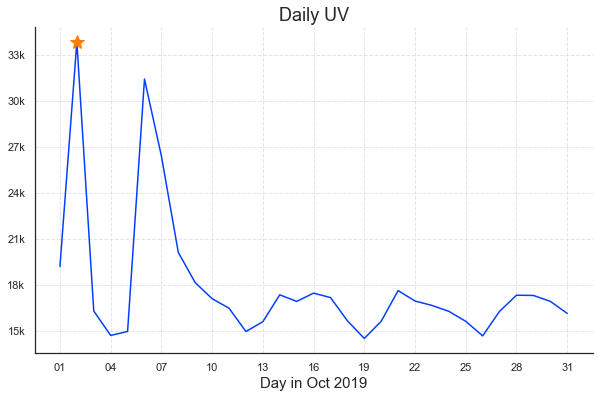

In [17]:
xlabel = range(1,32,2)

fig = plt.figure(figsize = (10,6))
sns.set(style = 'white', palette = 'bright')
ax = fig.add_subplot()
plt.plot(uv_d.day, uv_d.uv)
plt.plot(uv_d_max.day, uv_d_max.uv, marker = '*', markersize = 15)

plt.title('Daily UV', fontsize = 18)
plt.grid(linestyle = "--", alpha = 0.5)
plt.xlabel('Day in Oct 2019',fontsize = 15)
ax.set_yticks(range(15000,34000,3000))
ax.set_yticklabels(['15k','18k','21k','24k','27k','30k','33k'])
ax.set_xticks(['01','04','07','10','13','16','19','22','25','28','31'])
plt.grid(linestyle = "--", alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('2.11 daily UV.png')

网站当月的日PV、UV数整体呈相同的变化趋势，除10月2日、7日出现极高值外，其他时间均保持在相似水准，日PV处于130k左右，日UV处于16k左右。  
日PV、UV最高值均出现在10月2日，且显著高于其他日期，应后续对2日数据进行分析。

### hourly for all events
Use groupby to extract PV and UV data in different hours.  
For the hour is set from 0 to 23, add one row for 24 and set the data in this row the same as the data from 0.

In [154]:
pv_hour = df.groupby('hour').user_id.count().reset_index().rename(columns = {'user_id':'pv'})
#增加24点的数据，与0点相同，使后边的折线图连贯到24点
pv_hour.loc['24'] = pv_hour.iloc[0,1]

In [156]:
uv_hour = df.groupby('hour').user_id.nunique().reset_index().rename(columns = {'user_id':'uv'})
uv_hour.loc['24'] = uv_hour.iloc[0,1]

In [157]:
pv_h_max = pv_hour[pv_hour.pv == pv_hour.pv.max()]
pv_h_max

,hour,pv
19,19,264311


In [158]:
uv_h_max = uv_hour[uv_hour.uv == uv_hour.uv.max()]
uv_h_max

,hour,uv
12,12,39575


Draw the line plot for PV and UV in different hours:  
Use plt.plot to add marker for the highest data

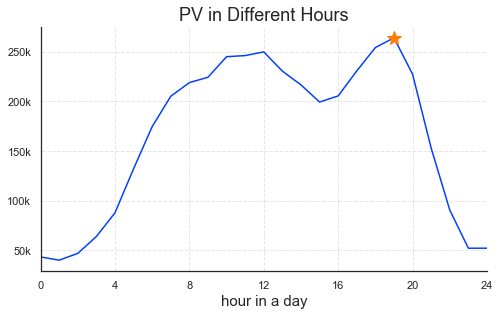

In [159]:
fig = plt.figure(figsize = (8,4.5))
sns.set(style = 'white', palette = 'bright')
ax = fig.add_subplot()
plt.plot(pv_hour.hour, pv_hour.pv)
plt.plot(pv_h_max.hour,pv_h_max.pv, marker = '*', markersize = 15)
ax.set_xticks(range(0,25,4))
plt.xlim(0,24)
ax.set_yticks(range(50000,250001, 50000))
ax.set_yticklabels(['50k','100k','150k','200k','250k'])
plt.xlabel('hour in a day', fontsize = 15)
plt.title('PV in Different Hours', fontsize = 18)
plt.grid(linestyle = '--', alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('2.11 hourly pv.png')

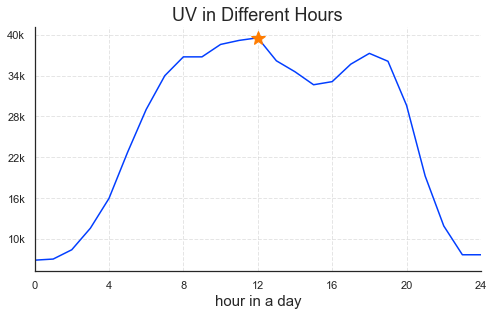

In [160]:
fig = plt.figure(figsize = (8,4.5))
sns.set(style = 'white', palette = 'bright')
ax = fig.add_subplot()
plt.plot(uv_hour.hour, uv_hour.uv)
plt.plot(uv_h_max.hour,uv_h_max.uv, marker = '*', markersize = 15)
ax.set_xticks(range(0,25,4))
plt.xlim(0,24)
ax.set_yticks(range(10000,40001,6000))
ax.set_yticklabels(['10k','16k','22k','28k','34k','40k'])
plt.title('UV in Different Hours', fontsize = 18)
plt.xlabel('hour in a day', fontsize = 15)
plt.grid(linestyle = '--', alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.savefig('2.11 hourly uv.png')

从日均每小时的UV、PV可以看出，用户主要在白天7点到20点的时间段内活跃，与20点到7点间的数据有明显的差异。白天的整体指标浮动不大，在中午12点，晚间18点稍有峰值出现。  
作为一个美妆销售网站，20点到24点的晚间用户访问量较低，此时段内应处于用户的晚间休息、网上购物时间。首先应考虑时差因素，分析此数据时区是否不是实际主要客户所处的时区。其次再考虑晚间的用户访问热度如何提升。

### Daily for each event type
Extract PV and UV data for four different event types in every day:  
Using the groupby method or pivor table method:

In [165]:
#daily
pv_event = df.groupby(['event_type','date']).user_id.count().reset_index().rename(columns = {'user_id':"pv"})
uv_event = df.groupby(['event_type','date']).user_id.nunique().reset_index().rename(columns = {'user_id':"uv"})

In [163]:
#The previous one also can use .unstack() to transfer to pivot table, or using following code:
#pd.pivot_table(pv_event, values = 'pv', index = 'date', 
#               columns = 'event_type')

Using sns.pointplot to draw the line plot with markers for each day data:

Text(0, 0.5, 'UV')

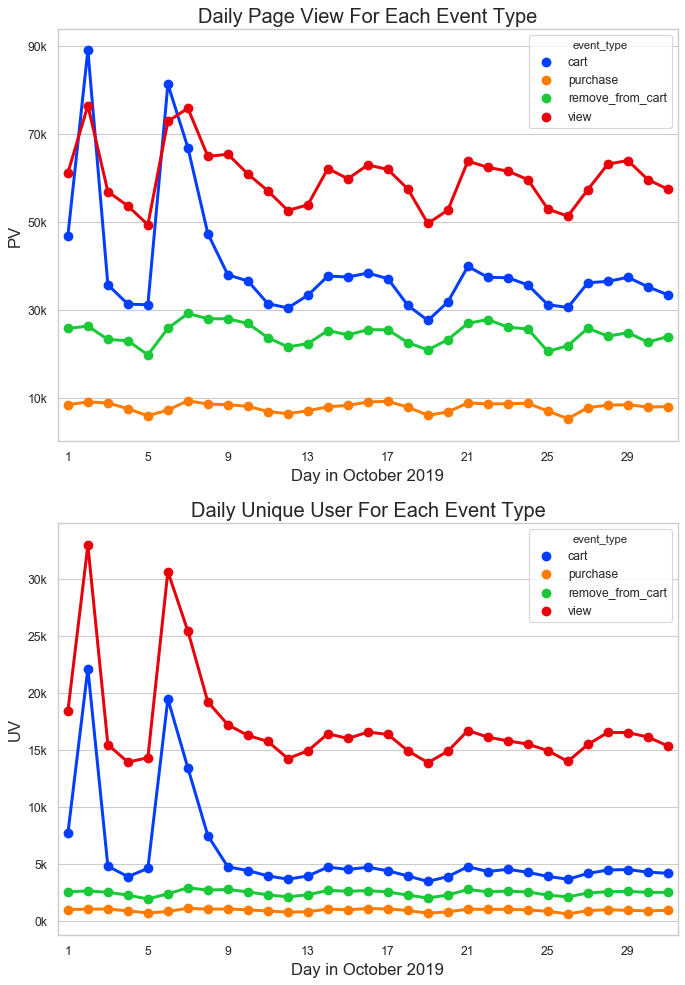

In [176]:
fig = plt.figure(figsize = (10, 15), dpi = 80)
sns.set(style = 'whitegrid', palette = 'bright')
ax = fig.add_subplot(2,1,1)
sns.pointplot(data = pv_event, x = 'date', y = 'pv', hue = 'event_type')
ax.set_xticks(range(0,pv_event.date.nunique()+1,4))
ax.set_xticklabels(range(1,pv_event.date.nunique()+1,4))
ax.set_yticks(range(10000,90001,20000))
ax.set_yticklabels(['10k','30k','50k','70k','90k'])
plt.title('daily page view for each event type'.title(), fontsize = 18)
plt.xlabel('Day in October 2019', fontsize = 15)
plt.ylabel('PV', fontsize = 15)
#plt.savefig('2.12 daily page view for each event type.png')

ax = fig.add_subplot(2,1,2)
sns.pointplot(data = uv_event, x = 'date', y = 'uv', hue = 'event_type')
ax.set_xticks(range(0,uv_event.date.nunique()+1,4))
ax.set_xticklabels(range(1,uv_event.date.nunique()+1,4))
ax.set_yticks(range(0,30001,5000))
ax.set_yticklabels(['0k','5k','10k','15k','20k','25k','30k'])
plt.title('daily unique user for each event type'.title(), fontsize = 18)
plt.xlabel('Day in October 2019', fontsize = 15)
plt.ylabel('UV', fontsize = 15)

整体而言，每日不同行为的PV、UV都呈现一个合理的从浏览、加入购物车到购买的逐渐减少的过程。  
对于上文中分析到的本月整体UV、PV异常的2日、6日两天数据，在通过根据行为拆分后可以发现，此二日的浏览、加购数据明显高于其他日期，但移出购物车或购买的行为与其他日期保持在相同水准，并无明显波动。可见无论由于渠道上升、网站活动获取其它原因导致网站在2日、6日客流量激增，增加带来的客流量并没有明显提升网站实际的成交数量。

### Hourly for each event type

Extract hourly PV and UV data for different event types  
add four rows for 24th hour in each event type, which equals to the data in at 0 a.m.

In [171]:
#hourly
pv_event_h = df.groupby(['event_type','hour']).user_id.count().reset_index().rename(columns = {'user_id':'pv'})
uv_event_h = df.groupby(['event_type','hour']).user_id.nunique().reset_index().rename(columns = {'user_id':'uv'})

In [172]:
#set 24 = 0
pv_event_h.loc['96'] = ['cart',24,pv_event_h.iloc[0,2]]
pv_event_h.loc['97'] = ['purchase',24,pv_event_h.iloc[24,2]]
pv_event_h.loc['98'] = ['remove_from_cart',24,pv_event_h.iloc[48,2]]
pv_event_h.loc['99'] = ['view',24,pv_event_h.iloc[72,2]]
print(pv_event_h.tail())
uv_event_h.loc['96'] = ['cart',24,uv_event_h.iloc[0,2]]
uv_event_h.loc['97'] = ['purchase',24,uv_event_h.iloc[24,2]]
uv_event_h.loc['98'] = ['remove_from_cart',24,uv_event_h.iloc[48,2]]
uv_event_h.loc['99'] = ['view',24,uv_event_h.iloc[72,2]]
print(uv_event_h.tail())

          event_type  hour     pv
95              view    23  21929
96              cart    24  17080
97          purchase    24   2082
98  remove_from_cart    24   7110
99              view    24  16743
          event_type  hour    uv
95              view    23  7227
96              cart    24  3632
97          purchase    24   192
98  remove_from_cart    24   751
99              view    24  6522


Use sns.pointplot draw the line plot with markers:

Text(0, 0.5, 'UV')

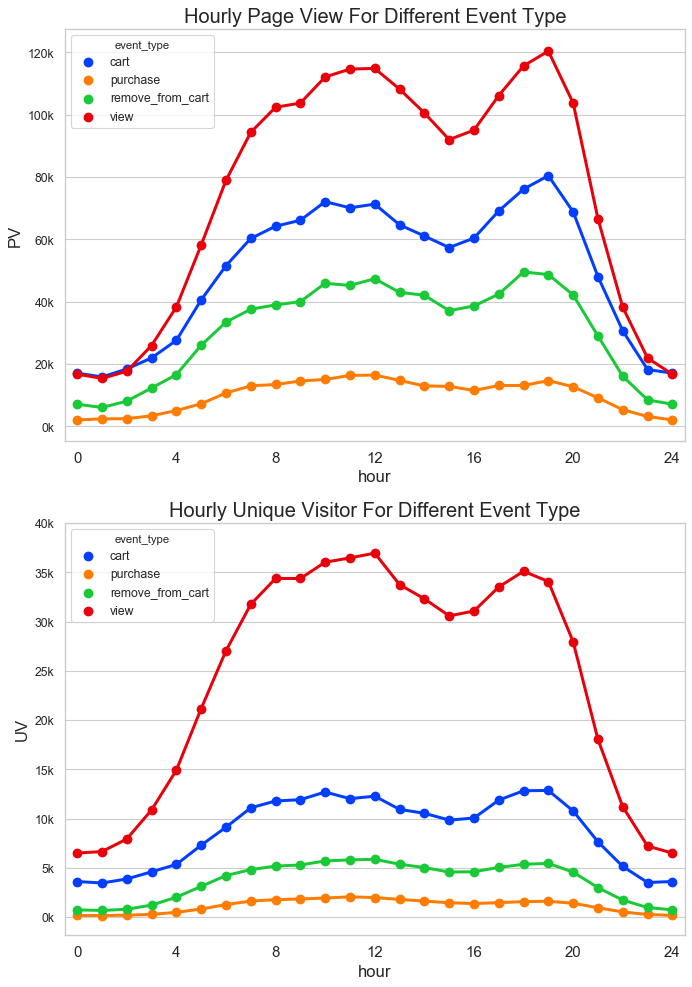

In [175]:
fig = plt.figure(figsize = (10,15), dpi = 80)
sns.set(style = 'whitegrid', palette = 'bright')
ax = fig.add_subplot(2,1,1)
sns.pointplot(data = pv_event_h,
             x = 'hour',
             y = 'pv',
             hue = 'event_type')
ax.set_xticks(range(0,25,4))
ax.set_xticklabels(range(0,25,4),fontsize = 13.5)
ax.set_yticks(range(0,120001, 20000))
ax.set_yticklabels(["0k","20k","40k","60k",'80k','100k','120k'])
plt.title('hourly page view for different event type'.title(), fontsize = 18)
plt.xlabel('hour',fontsize = 15)
plt.ylabel('PV', fontsize = 15)
#plt.savefig('2.13 hourly page view for different event type.png')

ax = fig.add_subplot(2,1,2)
sns.pointplot(data = uv_event_h,
             x = 'hour',
             y = 'uv',
             hue = 'event_type')
ax.set_xticks(range(0,25,4))
ax.set_xticklabels(range(0,25,4),fontsize = 13.5)
ax.set_yticks(range(0,40001, 5000))
ax.set_yticklabels(["0k","5k","10k","15k",'20k','25k','30k','35k','40k'])
plt.title('hourly unique visitor for different event type'.title(), fontsize = 18)
plt.xlabel('hour',fontsize = 15)
plt.ylabel('UV', fontsize = 15)

分活动类型的按小时PV、UV总体与整体PV、UV呈现统一水准，比较需要注意的是，从UV来看，最然浏览数在白天7到20点之间数据明显高于晚间、凌晨时段，但从加入购物车来看数据峰值有明显的减缓，从购买来看全天数据从清晨5点到晚间22点基本处于同一水准，日间浏览的高访问量并没有同等的转化到较高的购买水准。

## customer purchase behavior analysis
### customer buying frequency analysis
Calculate that how many times totally one user has purchased in this month.

In [200]:
daily_purchase_user = df[df.event_type == 'purchase'].groupby('user_id').event_type.count()
daily_purchase_user.describe()

count    25762.000000
mean         9.534353
std         11.341405
min          1.000000
25%          3.000000
50%          6.000000
75%         12.000000
max        329.000000
Name: event_type, dtype: float64

2019年10月本网站共有25,762名用户购买过商品，其中购买过的用户平均购买9.5次，购买次数中位数为6次，超过四分之三的用户购买次数少于12次，购买最多的用户本月购买329次。  
In total, 25,762 users has purchase event in October. The average purchase times is 9.5 and the median of purchase times is 6. 75% of purchased users purchase less than 12 times in October.   
Draw the histgram for total purchase time:

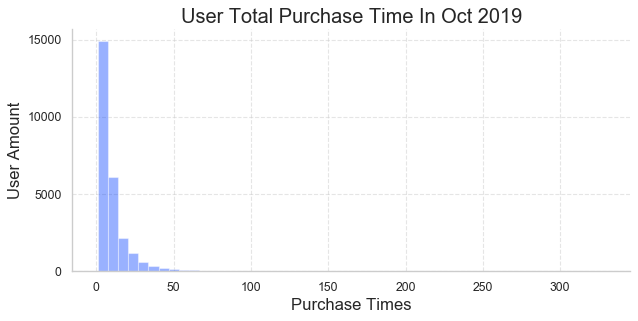

In [25]:
fig = plt.figure(figsize = (9,4), dpi = 80)
ax = fig.add_subplot()
sns.set(style = 'white', palette = 'bright')
sns.distplot(daily_purchase_user, kde = False)
plt.grid(linestyle = '--', alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('user total purchase time in Oct 2019'.title(), fontsize = 18)
plt.xlabel('Purchase Times',fontsize = 15)
plt.ylabel('User Amount', fontsize = 15)
ax.set_yticks(range(0,15001,5000))
#plt.savefig('2.21 user total purchase time in oct.png')

对购买次数最多的用户数据进行分析：

In [208]:
purchase_max_user_id = daily_purchase_user[daily_purchase_user == daily_purchase_user.max()].index.values
purchase_max_user_id

array([546827800], dtype=int64)

In [215]:
max_purchase = df[df.user_id == 546827800]
max_purchase.groupby(["user_session","event_type"]).agg({"event_time":"count",
                                                        "price":"sum",
                                                        "brand":"nunique"})

event_time    price  \
user_session                         event_type                              
0938c03d-f344-9d9d-e5cc-080d05f6e62c cart                     328  1010.35   
                                     remove_from_cart           9    93.64   
                                     view                       3    61.99   
1596ac11-a9f3-42f7-aee2-4fa824267fcb cart                       5    18.20   
                                     purchase                   4    16.30   
                                     remove_from_cart           5    75.10   
                                     view                       2    15.24   
346dd83e-e8f0-69df-085a-0cf4a806d70d cart                       6    78.42   
                                     purchase                 325   988.15   
                                     remove_from_cart         665  1923.94   
4f5a433e-a574-1192-4e82-6f620ef09cdb remove_from_cart           4    15.47   
                                     view                       1     2.38   
59d99afe-0dfd-46ab-a343-0ff129bcd272 view                       1     7.62   
7d044307-31bb-1058-a070-2b7964c6e367 cart                       9   121.80   
                                     remove_from_cart          19    88.25   
                                     view                       2   133.02   
8ee9515b-7244-3288-0bd8-d53dc7d3ffc4 cart                       5    76.80   
                                     view                       1     2.38   

                                                       brand  
user_session                         event_type               
0938c03d-f344-9d9d-e5cc-080d05f6e62c cart                  8  
                                     remove_from_cart      1  
                                     view                  0  
1596ac11-a9f3-42f7-aee2-4fa824267fcb cart                  2  
                                     purchase              1  
                                     remove_from_cart      4  
                                     view                  1  
346dd83e-e8f0-69df-085a-0cf4a806d70d cart                  2  
                                     purchase             10  
                                     remove_from_cart     11  
4f5a433e-a574-1192-4e82-6f620ef09cdb remove_from_cart      2  
                                     view                  1  
59d99afe-0dfd-46ab-a343-0ff129bcd272 view                  1  
7d044307-31bb-1058-a070-2b7964c6e367 cart                  4  
                                     remove_from_cart      2  
                                     view                  1  
8ee9515b-7244-3288-0bd8-d53dc7d3ffc4 cart                  2  
                                     view                  1

In [218]:
print("购买订单数量最大用户的上线日期：",max_purchase.date.unique())
print("购买订单最多用户每个session的付费金额：")
max_pay_session = max_purchase[max_purchase.event_type == "purchase"].groupby("user_session").price.sum()
print(max_pay_session)

购买订单数量最大用户的上线日期： ['2019-10-04T00:00:00.000000000' '2019-10-10T00:00:00.000000000'
 '2019-10-14T00:00:00.000000000' '2019-10-15T00:00:00.000000000']
购买订单最多用户每个session的付费金额：
user_session
1596ac11-a9f3-42f7-aee2-4fa824267fcb     16.30
346dd83e-e8f0-69df-085a-0cf4a806d70d    988.15
Name: price, dtype: float64


In [229]:
max_purchase_event = df[(df.user_session == "346dd83e-e8f0-69df-085a-0cf4a806d70d") & (df.event_type == "purchase")]
print(max_purchase_event.brand.unique())
max_purchase_event.groupby("brand").agg({"price":["sum","max"],"event_time":"count"})

['milv' 'irisk' 'bpw.style' nan 'freedecor' 'nagaraku' 'runail' 'jessnail'
 'emil' 'grattol' 'swarovski']


price        event_time
              sum    max      count
brand                              
bpw.style   31.93   0.95         39
emil        93.65  93.65          1
freedecor   16.76   0.95         20
grattol    442.29   6.27         87
irisk       99.19  82.54          9
jessnail    63.48  63.48          1
milv        40.74   0.95         56
nagaraku     0.95   0.95          1
runail      30.57  17.86         33
swarovski    7.56   5.08          3

该用户的所有购买行为共计上线4天，行为出现在7个不同的session中；但实际成交只有两个session，其中一个session下单325次，总金额只有988.15，涉及10个品牌

### Daily GMV

In [5]:
daily_revenue = df[df.event_type == 'purchase'].groupby('date').price.sum().reset_index()

In [7]:
daily_revenue.describe()

,price
count,31.000000
mean,39081.884839
std,5482.727590
min,25359.180000
25%,35786.725000
50%,40471.080000
75%,43189.455000
max,46837.580000


Text(0, 0.5, 'Total GMV')

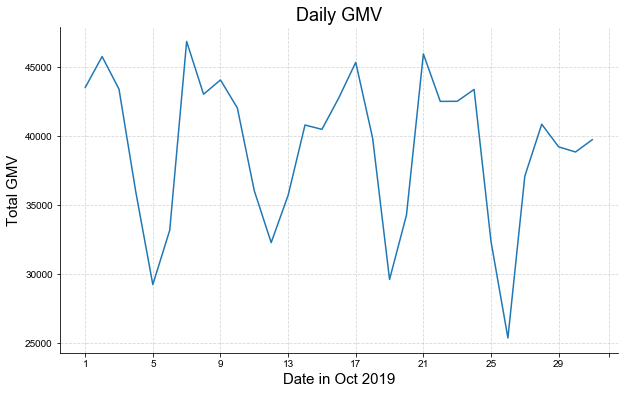

In [6]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
sns.set(style = 'white', palette = 'bright')
plt.plot(daily_revenue["date"],daily_revenue["price"])
plt.grid(linestyle = '--', alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(range(1,daily_revenue.date.nunique()+1,4))
plt.title("Daily GMV", fontsize=18)
plt.xlabel("Date in Oct 2019", fontsize=15)
plt.ylabel("Total GMV", fontsize=15)

网站的日GMV呈周期性变化，大多数日期GMV保持在35000到43000之前，每周六的经营状况明显低于一周中的其他时间。

### Daily ARPPU(average revenue per paying user)
Extract the total revenue for each day and the number of unique purchased users.  
Calculate the ARPPU = daily total revenue / daily total unique purchaser:

In [8]:
daily_revenue = df[df.event_type == 'purchase'].groupby('date').price.sum().reset_index()
daily_pay_user = df[df.event_type == 'purchase'].groupby('date').user_id.nunique().reset_index()

In [9]:
daily_arppu = pd.merge(daily_revenue,daily_pay_user, on = 'date')
daily_arppu.head()

,date,price,user_id
0,2019-10-01,43497.17,1001
1,2019-10-02,45746.20,1045
2,2019-10-03,43380.98,1048
3,2019-10-04,35887.15,892
4,2019-10-05,29228.55,708


In [10]:
daily_arppu['arppu'] = daily_arppu.price/daily_arppu.user_id
daily_arppu['day'] = daily_arppu.date.dt.strftime('%d')
daily_arppu.head()

,date,price,user_id,arppu,day
0,2019-10-01,43497.17,1001,43.453716,01
1,2019-10-02,45746.20,1045,43.776268,02
2,2019-10-03,43380.98,1048,41.394065,03
3,2019-10-04,35887.15,892,40.232231,04
4,2019-10-05,29228.55,708,41.283263,05


In [29]:
daily_arppu.arppu.describe()

count    31.000000
mean     41.796211
std       1.539633
min      38.014653
25%      41.033328
50%      41.675516
75%      42.981685
max      44.384135
Name: arppu, dtype: float64

Text(0, 0.5, 'ARPPU')

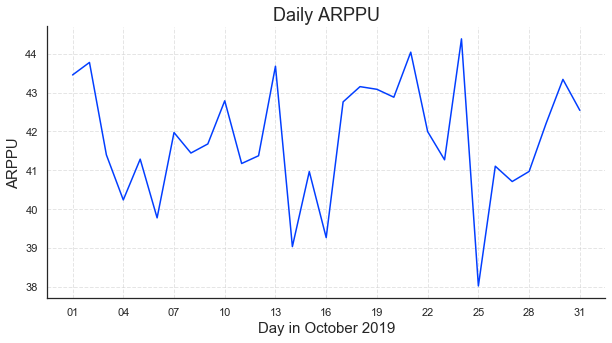

In [11]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()
plt.plot(daily_arppu.day, daily_arppu.arppu)
plt.title('Daily ARPPU', fontsize = 18)
plt.grid(linestyle = '--', alpha =0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(range(0,33,3))
plt.xlabel('Day in October 2019',fontsize = 15)
plt.ylabel('ARPPU',fontsize = 15)
#plt.savefig('2.23 Daily ARPPU.png')

### Daily ARPU(Average Revenue per user)
extract amount of daily actived users  
calculate ARPU = daily total revenue/daily actived users

In [14]:
daily_user = df.groupby('date').user_id.nunique().reset_index().rename(columns = {"user_id":"daily_active"})
daily_user.head()

,date,daily_active
0,2019-10-01,19230
1,2019-10-02,33859
2,2019-10-03,16323
3,2019-10-04,14732
4,2019-10-05,14990


In [15]:
daily_arpu = pd.merge(daily_revenue, daily_user, on = 'date')
daily_arpu['arpu'] = daily_arpu.price/daily_arpu.daily_active
daily_arpu['day'] = daily_arpu.date.dt.strftime('%d')
daily_arpu.arpu.describe()

count    31.000000
mean      2.239887
std       0.365562
min       1.054989
25%       2.144566
50%       2.290572
75%       2.455266
max       2.659999
Name: arpu, dtype: float64

Text(0, 0.5, 'ARPU')

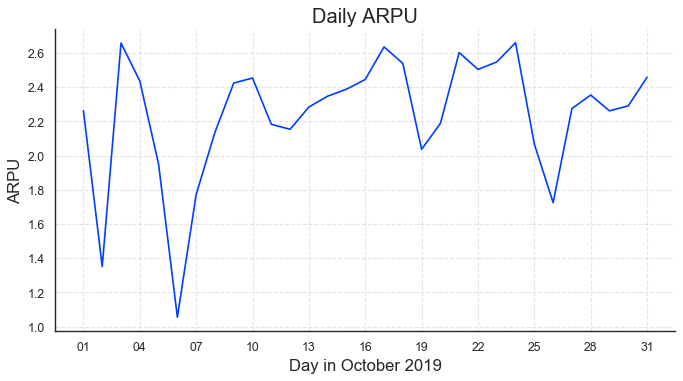

In [16]:
fig = plt.figure(figsize = (10,5), dpi = 80)
ax = fig.add_subplot()
plt.plot(daily_arpu.day, daily_arpu.arpu)
plt.title('Daily ARPU', fontsize = 18)
plt.grid(linestyle = '--', alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(range(0,33,3))
plt.xlabel('Day in October 2019',fontsize = 15)
plt.ylabel('ARPU',fontsize = 15)
#plt.savefig('2.23 Daily ARPU.png')

与网站的日GMV相比，网站日ARPU、ARPPU的变化周期性较不明显，这主要受到当月每日用户数量没有呈明显的周期变化的影响。尤其从ARPU来看，2日、6日两天较大的用户基数明显拉低了当天的ARPU，而后续数据逐渐趋于平稳。

### pay user rate
pay user rate = total paied user/total active user

In [18]:
daily_pay_user = df[df.event_type == 'purchase'].groupby('date').user_id.nunique().reset_index().rename(columns = {'user_id':'daily_pay_user'})

In [19]:
daily_pay_rate = daily_pay_user.daily_pay_user/daily_user.daily_active
mean = daily_pay_rate.mean()
daily_pay_rate.describe()

count    31.000000
mean      0.053604
std       0.008662
min       0.026528
25%       0.051794
50%       0.055876
75%       0.059352
max       0.064204
dtype: float64

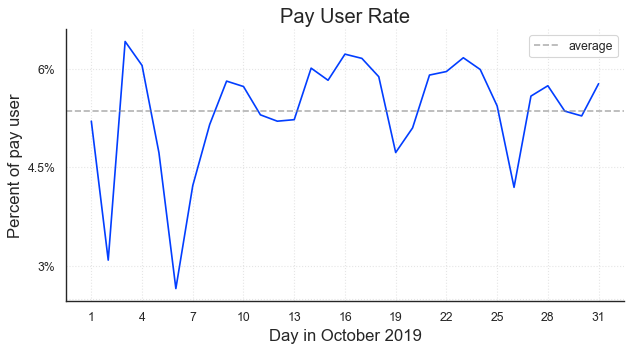

In [20]:
fig = plt.figure(figsize = (9, 4.5), dpi = 80)
ax = fig.add_subplot()
day = daily_pay_user.date.dt.day
plt.plot(day, daily_pay_rate)
plt.title('Pay User Rate', fontsize = 18)
plt.xlabel('Day in October 2019', fontsize = 15)
plt.ylabel('Percent of pay user', fontsize = 15)
ax.set_yticks([0.025,0.03, 0.045, 0.06])
ax.set_yticklabels(["",'3%','4.5%','6%'])
ax.set_xticks(range(1,32,3))
plt.grid(linestyle = ':', alpha = 0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(mean, linestyle = "--", color = 'grey', alpha = 0.6, label = 'average')
plt.legend()
#plt.savefig('2.24 Pay User Rage.png')

与ARPU的变化情况相似，付费用户占比同样在2日、6日受到总活跃用户数的影响，导致数据明显低于其他时间段。

## Retention Rate
### all user retention

In [33]:
user_num = df.groupby("date")["user_id"].unique()
user_num.head()

date
2019-10-01    [463240011, 429681830, 430174032, 377667011, 4...
2019-10-02    [555815087, 555815138, 555815115, 555815140, 5...
2019-10-03    [538931315, 430209260, 418167791, 536189308, 2...
2019-10-04    [455300469, 509042489, 556530981, 556546665, 4...
2019-10-05    [417143062, 556829500, 464592812, 411689951, 5...
Name: user_id, dtype: object

In [48]:
from datetime import timedelta
def retention_rate(user_data, n):
    """求所有用户n日留存率"""
    date_list = []
    retention_dayn = []
    date1 = pd.Series(user_data.index[:-n])
    for date in date1:
        daten = date+timedelta(n)
        user_dayone = user_data[user_data.index == date].values[0]
        """处理新用户
        new_user = set
        """
        user_dayn = user_data[user_data.index == daten].values[0]
        day_first = len(user_dayone)
        day_n = 0
        for user in user_dayn:
            if user in user_dayone:
                day_n += 1
        date_list.append(date.strftime("%d-%m-%y"))
        retention = round(day_n/day_first,4)
        retention_dayn.append(retention)
    return date_list, retention_dayn

In [49]:
day_list2, retention_2days = retention_rate(user_num, 2)
day_list7, retention_7days = retention_rate(user_num, 7)

In [50]:
print("次日留存均值：", round(np.mean(retention_2days),4),
      "\n次日留存中位数值：", round(np.median(retention_2days), 4))
print("7日留存均值：", round(np.mean(retention_7days),4),
     "\n7日留存中位数值：", round(np.median(retention_7days), 4))

次日留存均值： 0.0811 
次日留存中位数值： 0.0843
7日留存均值： 0.0564 
7日留存中位数值： 0.0584


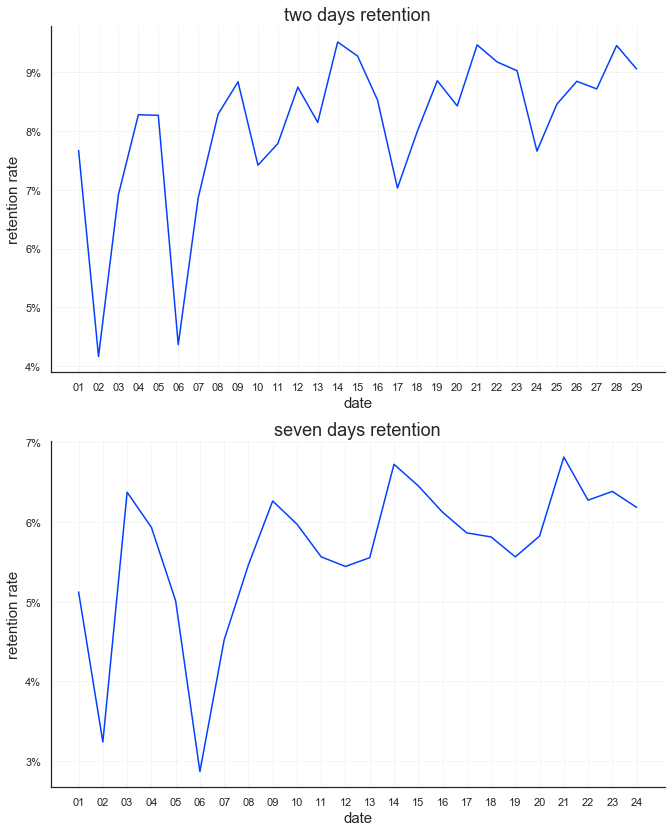

In [44]:
fig = plt.figure(figsize=(11,14))
ax = fig.add_subplot(2,1,1)
plt.plot(day_list2, retention_2days)
x_label = []
for day in day_list2:
    x_label.append(day[:2])
plt.xticks(range(len(day_list2)),x_label)
plt.yticks([0.04, 0.05, 0.06, 0.07, 0.08, 0.09], ["4%","5%","6%","7%","8%","9%"])
plt.title("two days retention", size=18)
plt.xlabel("date", size=15)
plt.ylabel("retention rate", size=15)
plt.grid(linestyle = ':', alpha = 0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax = fig.add_subplot(2,1,2)
plt.plot(day_list7, retention_7days)
x_label = []
for day in day_list7:
    x_label.append(day[:2])
plt.xticks(range(len(day_list7)),x_label)
plt.yticks([0.03, 0.04, 0.05, 0.06, 0.07], ["3%","4%","5%","6%","7%"])
plt.title("seven days retention", size=18)
plt.xlabel("date", size=15)
plt.ylabel("retention rate", size=15)
plt.grid(linestyle = ':', alpha = 0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

本网站的次日留存、七日留存整体数据趋势类似，同样排除2日、6日用户异常过大的情况外，整体次日留存保持在8%到9%的水准，7日留存保持在6%附近的水准。  
但总体来看，该网站用户留存率较低

### Compare retention rate between all users and purchased users

In [45]:
purchased = df[df.event_type == "purchase"]
user_num_purchased = purchased.groupby("date")["user_id"].unique()

In [51]:
day_list7, retention_7days_all = retention_rate(user_num, 7)
day_list7, retention_7days_purchase = retention_rate(user_num_purchased, 7)

In [52]:
print("所有用户7日留存均值：", round(np.mean(retention_7days_all),4),
      "\n购买用户7日留存中位数值：", round(np.median(retention_7days_all), 4))
print("所有用户7日留存均值：", round(np.mean(retention_7days_purchase),4),
     "\n购买用户7日留存中位数值：", round(np.median(retention_7days_purchase), 4))

所有用户7日留存均值： 0.0564 
购买用户7日留存中位数值： 0.0584
所有用户7日留存均值： 0.0125 
购买用户7日留存中位数值： 0.0128


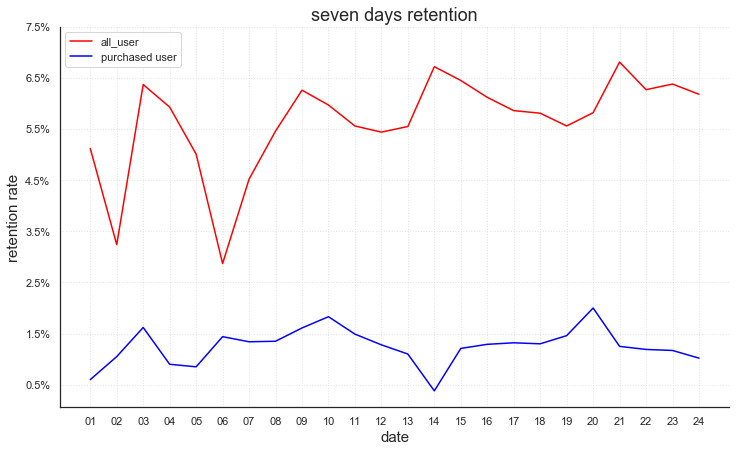

In [56]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
plt.plot(day_list7, retention_7days_all, c="red", label="all_user")
plt.plot(day_list7, retention_7days_purchase, c="blue", label="purchased user")
x_label = []
for day in day_list7:
    x_label.append(day[:2])
plt.xticks(range(len(day_list7)),x_label)
plt.yticks([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075], 
           ["0.5%","1.5%","2.5%","3.5%","4.5%","5.5%","6.5%","7.5%"])
plt.title("seven days retention", size=18)
plt.xlabel("date", size=15)
plt.ylabel("retention rate", size=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.grid(linestyle = ':', alpha = 0.5)
plt.legend()

从上图比较可以看出，有购买行为的用户七日留存率整体均明显低于所有用户水准，说明用户在完成以此购买后七日内缺少再次使用网站的行为。考虑到该网站售卖内容为美妆相关，不存在用户购买的是较低频率使用的物品，该网站应该思考如何加强用户购买后七天再次访问该网站，如通过email推送最新优惠，提醒用户对购买过的订单进行评价等。  
此外，有购买行为的用户整体留存率比较稳定，但整体留存水准很低。

## repurchase rate
### repurchase times
Extract purchase times for all purcased users: Use different user sessions to define a repurchase  

In [59]:
buy = df[df.event_type == 'purchase'].groupby(['user_id']).user_session.nunique().reset_index().rename(columns = {'user_session':'times'})
buy.head()

,user_id,times
0,29025780,1
1,31229488,1
2,33535391,1
3,33609704,1
4,34080306,1


Seperate the users who purchase more than once.  
calculate repurchase rate and draw histgram for repurchase times.

In [60]:
rebuy_amount = buy[buy.times >= 2]
rebuy_amount['re_times'] = rebuy_amount.times-1
rebuy_amount.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,times,re_times
25,69749548,2,1
45,92366748,2,1
47,95758554,3,2
70,121496884,2,1
81,140439288,2,1


In [61]:
rebuy_amount.re_times.describe()

count    2709.000000
mean        1.315615
std         1.034335
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        30.000000
Name: re_times, dtype: float64

Repurchase rate is 0.1052


(array([2.693e+03, 1.400e+01, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. ]),
 <a list of 5 Patch objects>)

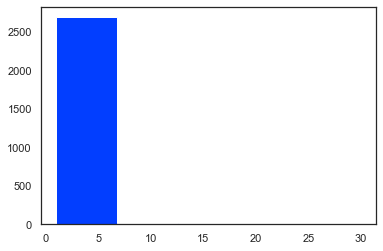

In [63]:
repurchase_rate = round(len(rebuy_amount)/len(buy),4)
print('Repurchase rate is {}'.format(repurchase_rate))
sns.set(style = 'white', palette = 'bright')
plt.hist(rebuy_amount.re_times, bins = 5)

For more than 75% of users only repurchase once, use pd.cut to seperate the repurchase time to 1, 2, 3 and more than 3 in order to draw pie chart.

In [64]:
bins_rebuy = [0,1,2,100]
labels_rebuy = ['once','twice',"more than twice"]
rebuy_amount['bins'] = pd.cut(rebuy_amount.re_times,bins = bins_rebuy, labels = labels_rebuy)
rebuy_amount.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,times,re_times,bins
25,69749548,2,1,once
45,92366748,2,1,once
47,95758554,3,2,twice
70,121496884,2,1,once
81,140439288,2,1,once


In [65]:
rebuy_bins_per = rebuy_amount.groupby('bins').user_id.count().reset_index()
rebuy_bins_per['per'] = rebuy_bins_per.user_id/rebuy_bins_per.user_id.sum()
rebuy_bins_per

,bins,user_id,per
0,once,2190,0.808416
1,twice,370,0.136582
2,more than twice,149,0.055002


Text(0.5, 1.0, 'Total Repurchase Times')

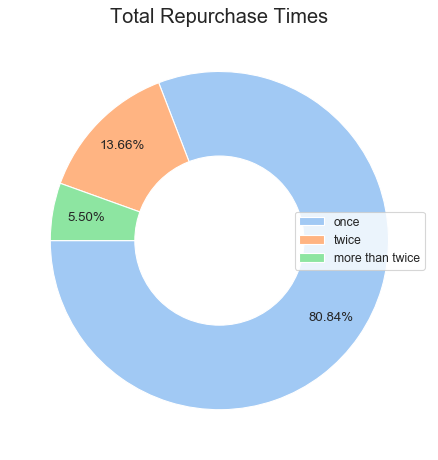

In [66]:
fig = plt.figure(figsize = (9,7), dpi = 80)
sns.set(style = 'white', palette = 'pastel')
plt.pie(rebuy_bins_per.user_id, autopct = "%.2f%%",
       pctdistance = 0.8,
       startangle = 180)
plt.pie([1,0], radius = 0.5, colors = 'w')
plt.legend(labels = labels_rebuy, loc = 5)
plt.title('Total Repurchase Times', fontsize = 18)
#plt.savefig('2.31 total repurchase times.png')

通过定义用户在不同的user session(用户一次登录后过一段较长时间再次登录为新的session)有购买行为有复购行为，用户的购买频率为在多少个不同的user session购买过。  
通过上述统计可以看出仅有10%的用户在当月有过复购行为，且其中八成有复购行为的用户仅在此购买过一次商品。由此复购频率较低也可以反映出上文有购买行为的用户留存率更低，是因为其不需要再本网站进行高频率的商品购买。  

### repurchase time gap
Calculate the repurchase time gap between a user first purchase and the last purchse in this month.  
Extract the min and max purchase time from repurchase users.

In [76]:
def repur_gap_max(user_record_date):
    """求一个用户复购的最大日期间隔"""
    max_gap = user_record_date[1]-user_record_date[0]
    if len(user_record_date)>=3:
        for x in range(1, len(user_record_date)-1):
            date1 = user_record_date[x]
            date2 = user_record_date[x+1]
            gap = date2-date1
            if gap > max_gap:
                max_gap = gap
    return max_gap

In [67]:
purchase = df[df.event_type == 'purchase']
repur = purchase.groupby(['user_id']).user_session.count().reset_index()
repur_data = purchase[purchase.user_id.isin(repur[repur.user_session>=2].user_id)]
repur_time_gap = repur_data.groupby(['user_id']).date.apply(lambda x: x.max()-x.min())
repur_time_gap.head()

user_id
29025780   5 days
31229488   0 days
33535391   0 days
33609704   0 days
34080306   0 days
Name: date, dtype: timedelta64[ns]

In [68]:
repur_time_gap = repur_time_gap.reset_index()
repur_time_gap.head()

,user_id,date
0,29025780,5 days
1,31229488,0 days
2,33535391,0 days
3,33609704,0 days
4,34080306,0 days


In [69]:
repur_time_gap.date = repur_time_gap.date.dt.days

In [70]:
repur_time_gap.date.describe()

count    23324.000000
mean         1.246441
std          4.405746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         30.000000
Name: date, dtype: float64

Repurchase is defined as user who purchase on different days, so the time gap zero day is removed.

In [71]:
timegap_nosameday = repur_time_gap.date[repur_time_gap.date > 0]
timegap_nosameday.describe()

count    2492.000000
mean       11.666132
std         7.754571
min         1.000000
25%         5.000000
50%        11.000000
75%        18.000000
max        30.000000
Name: date, dtype: float64

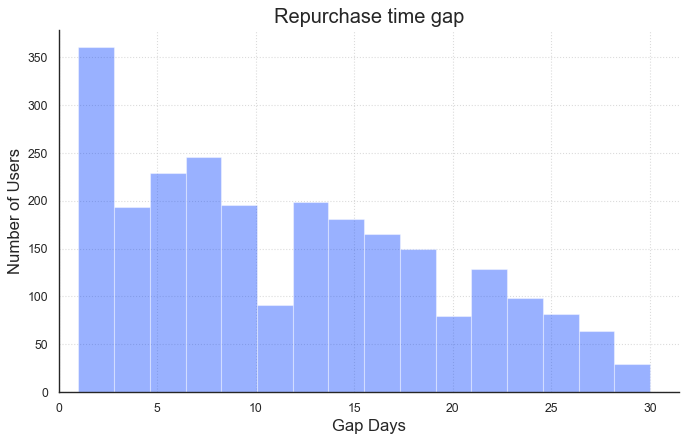

In [72]:
fig = plt.figure(figsize = (10,6), dpi = 80)
ax = fig.add_subplot()
sns.set(style = 'white', palette = 'bright')
sns.distplot(timegap_nosameday, bins = 16,kde = False, color = 'b')
plt.xlim(xmin = 0)
plt.title('Repurchase time gap',fontsize = 18)
plt.xlabel('Gap Days', fontsize = 15)
plt.grid(linestyle = ':', alpha = 0.7)
plt.ylabel('Number of Users', size = 15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_xticks(range(1,31,2))
#plt.savefig('2.32 Repurchase time gap.png')

有复购行为的用户，除当天、第二天就进行再次购买外，其他在本月购买行为的最大时间间隔比较均匀的分部在2到30天。

## single user payment in total

In [83]:
single_pay = purchase.groupby("user_id").price.sum()
single_pay.describe()

count    25762.000000
mean        47.028120
std         55.697229
min         -3.020000
25%         16.490000
50%         32.380000
75%         54.947500
max       1295.480000
Name: price, dtype: float64

大部分有购买行为的用户本月在网站的总付费在15到55元。

# 制作漏斗图 calculate funnel

## split and merge four phases data
定义一个转化路径为同一个用户对同一个商品，从浏览到加购到下单，或从浏览到加购到移除购物车。  
The data is splited based on four event types. Then, the data from four phases is merged on the same user id and the same product id, which can be used to understand whether the same user do the next phase event for the same product.  
Also, for the data only includes the event history in October, some events may links to the previous history. For instance, a product may be added to cart in September and remove from cart in October. This type of data is excluded in the conversion rate analysis. 

In [4]:
df_view = df[df.event_type == 'view']
df_cart = df[df.event_type == 'cart']
df_rf_cart = df[df.event_type == 'remove_from_cart']
df_purchase = df[df.event_type == 'purchase']

### view to cart

In [5]:
df_v_to_c = pd.merge(left = df_view[['time',
                              'product_id','user_id',
                              'brand','price','category_id','category_code']], 
                     right = df_cart[['time','user_id','product_id']],
                     on = ['user_id','product_id'], how = 'left',
                     suffixes = ['_view','_cart'])

In [6]:
df_v_to_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2166987 entries, 0 to 2166986
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time_view      object 
 1   product_id     int64  
 2   user_id        int64  
 3   brand          object 
 4   price          float64
 5   category_id    int64  
 6   category_code  object 
 7   time_cart      object 
dtypes: float64(1), int64(3), object(4)
memory usage: 148.8+ MB


In [87]:
df_v_to_c.head()

,time_view,product_id,user_id,brand,price,category_id,category_code,time_cart
0,00:00:26,5875317,474232307,NaN,1.59,2029082628195353599,NaN,00:01:13
1,00:00:28,5692917,555446068,lianail,5.54,1487580004857414477,NaN,NaN
2,00:00:48,5819638,546705258,NaN,21.75,1487580008162526182,NaN,NaN
3,00:00:53,5856191,507355498,runail,24.44,1487580006350586771,appliances.environment.vacuum,NaN
4,00:01:11,5733176,543446752,NaN,0.60,1487580009362096156,NaN,NaN


### cart to remove from cart

In [7]:
df_v_c_r = pd.merge(left = df_v_to_c[['time_view','time_cart',
                              'product_id','user_id',
                              'brand','price','category_id','category_code']], 
                     right = df_rf_cart[['time','user_id','product_id']],
                     on = ['user_id','product_id'], how = 'left',
                     suffixes = ['_cart','_rf_cart'])
df_v_c_r.rename(columns = {'time':'time_rf_cart'},inplace = True)
df_v_c_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2811578 entries, 0 to 2811577
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time_view      object 
 1   time_cart      object 
 2   product_id     int64  
 3   user_id        int64  
 4   brand          object 
 5   price          float64
 6   category_id    int64  
 7   category_code  object 
 8   time_rf_cart   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 214.5+ MB


### cart to buy

In [8]:
df_v_c_b = pd.merge(left = df_v_to_c[['time_view','time_cart',
                              'product_id','user_id',
                              'brand','price','category_id','category_code']], 
                     right = df_purchase[['time','user_id','product_id']],
                     on = ['user_id','product_id'], how = 'left',
                     suffixes = ['_cart','_rf_cart'])
df_v_c_b.rename(columns = {'time':'time_purchase'},inplace = True)
df_v_c_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188536 entries, 0 to 2188535
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   time_view      object 
 1   time_cart      object 
 2   product_id     int64  
 3   user_id        int64  
 4   brand          object 
 5   price          float64
 6   category_id    int64  
 7   category_code  object 
 8   time_purchase  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 167.0+ MB


## funnel data calculate

In [9]:
df_v_to_c1 = df_v_to_c.groupby(['user_id','product_id']).time_cart.nunique().reset_index()
df_v_to_c1.head()

,user_id,product_id,time_cart
0,4103071,5563536,0
1,4103071,5670334,0
2,4103071,5735272,0
3,4103071,5784982,0
4,4103071,5795273,0


In [10]:
view_num = len(df_v_to_c1)
cart_num = view_num - len(df_v_to_c1[df_v_to_c1.time_cart == 0])
v_to_c_rate = round(cart_num/view_num,4)
print("number of view users: {}, number of add cart users:{},v_to_c rate is {}".format(view_num, cart_num, v_to_c_rate))

number of view users: 1402922, number of add cart users:326246,v_to_c rate is 0.2325


In [11]:
df_c_to_r1 = df_v_c_r.groupby(['user_id','product_id']).time_rf_cart.nunique().reset_index()
df_c_to_r1.head()

,user_id,product_id,time_rf_cart
0,4103071,5563536,0
1,4103071,5670334,0
2,4103071,5735272,0
3,4103071,5784982,0
4,4103071,5795273,0


In [12]:
rf_num = len(df_c_to_r1[df_c_to_r1.time_rf_cart != 0])
rf_num
c_to_rf_rate = round(rf_num/cart_num,4)

In [13]:
df_v_c_b1 = df_v_c_b.groupby(['product_id','user_id']).time_purchase.nunique().reset_index()
df_v_c_b1.head()

,product_id,user_id,time_purchase
0,3752,306131139,0
1,3752,525448973,0
2,3752,543825317,0
3,3752,552966434,0
4,3752,558771491,0


In [14]:
b_num = len(df_v_c_b1[df_v_c_b1.time_purchase != 0])
b_num
c_to_b_rate = round(b_num/cart_num,4)

In [15]:
print("""
number of view is:{}
number of add to cart is :{}
number of remove from cart is:{}
number of purchase is :{}
rate from view to add to cart is:{:.2%}
rate from add to cart to remove is:{:.2%}
rate from add to cart to purchase is: {:.2%}
""".format(view_num, cart_num, rf_num, b_num,v_to_c_rate,c_to_rf_rate, c_to_b_rate))


number of view is:1402922
number of add to cart is :326246
number of remove from cart is:151954
number of purchase is :86771
rate from view to add to cart is:23.25%
rate from add to cart to remove is:46.58%
rate from add to cart to purchase is: 26.60%



## plot the funnel

In [18]:
from pyecharts.charts import Funnel
from pyecharts import options as opts
#https://mp.weixin.qq.com/s/7Iu8kp85nHRSlzhpHBSNJw

event = ['view','add to chart','purchase']
event_num = [view_num, cart_num, b_num]
funnel = (Funnel()
         .add("cosmetic ecommerce", [list(z) for z in zip(event, event_num)],
             label_opts=opts.LabelOpts(position="inside"))
         .set_global_opts(title_opts=opts.TitleOpts(title="User Event", subtitle="Funnel")))
funnel.render_notebook()

# product category analysis

In [100]:
brandtop10 = df.brand.value_counts()[:10]
brandtop10 = brandtop10.reset_index().rename(columns = {"index":"top_brand","brand":"count"})
brandtop10.head()

,top_brand,count
0,runail,306239
1,irisk,226589
2,masura,195170
3,grattol,132130
4,bpw.style,114192


In [73]:
brand_event = df[df.brand.isin(brandtop10.top_brand)].groupby(['brand','event_type']).user_id.count().unstack().reset_index()

In [74]:
brand_event.head()

event_type,brand,cart,purchase,remove_from_cart,view
0,bpw.style,37785,9506,23576,43325
1,estel,16207,3211,8035,36989
2,grattol,33494,6438,24327,67871
3,ingarden,27948,5181,22060,35091
4,irisk,78293,15645,47330,85321


In [75]:
brand_event['v_to_c'] = brand_event.cart/brand_event.view
brand_event['c_to_b'] = brand_event.purchase/brand_event.cart
brand_event

event_type,brand,cart,purchase,remove_from_cart,view,v_to_c,c_to_b
0,bpw.style,37785,9506,23576,43325,0.872129,0.251581
1,estel,16207,3211,8035,36989,0.438157,0.198124
2,grattol,33494,6438,24327,67871,0.493495,0.192214
3,ingarden,27948,5181,22060,35091,0.796444,0.185380
4,irisk,78293,15645,47330,85321,0.917629,0.199826
5,kapous,14576,3117,7306,32916,0.442824,0.213845
6,masura,58657,11356,45649,79508,0.737750,0.193600
7,pole,19789,3360,15048,23408,0.845395,0.169791
8,runail,98737,21936,65957,119609,0.825498,0.222166
9,uno,13307,3218,8169,23334,0.570284,0.241828


In [76]:
brand_event_vb = brand_event.sort_values(by = 'v_to_c', ascending = False)

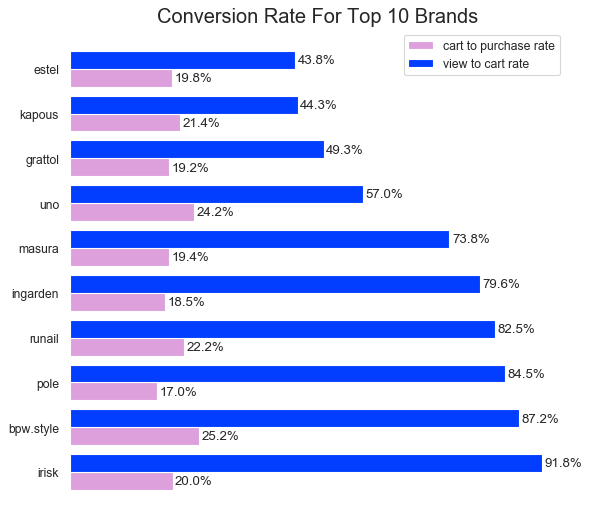

In [77]:
fig = plt.figure(figsize = (8,8), dpi = 80)
ax = fig.add_subplot()
sns.set(style = 'white', palette = 'pastel')
bar1y = [(2*i + 0.8*1) for i in range(len(brand_event_vb.c_to_b))]
bar2y = [(2*i + 0.8*2) for i in range(len(brand_event_vb.v_to_c))]
plt.barh(bar1y, brand_event_vb.c_to_b, color = 'plum', label = 'cart to purchase rate')
plt.barh(bar2y, brand_event_vb.v_to_c, label = 'view to cart rate')
#plt.vlines(brand_event_vb.v_to_c.mean(),ymin = -1, ymax = len(brand_event_vb),
#          linestyle = '--',color = 'grey', alpha = 0.8,
 #         label = 'mean: {}'.format(round(brand_event_vb.v_to_c.mean(),4)))
#ax.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
#ax.set_xticklabels(["0%","20%","40%","60%","80%","100%"])
ax.set_xticks([])
y =[]
for y1, y2 in zip(bar1y, bar2y):
    a = (y1+y2)/2
    y.append(a)
ax.set_yticks(y)
ax.set_yticklabels(brand_event_vb.brand)
plt.title('conversion rate for top 10 brands'.title(), fontsize = 18)

for x,y in zip(brand_event_vb.c_to_b, bar1y):
    plt.text(x+0.005, y-0.15, ("%.1f%%")%(x*100))
for x,y in zip(brand_event_vb.v_to_c, bar2y):
    plt.text(x+0.005, y-0.15, ("%.1f%%")%(x*100))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend()
#plt.savefig('4.1 Conversion Rate for top10 brands.png')

# 20:80
## top 20 user

In [78]:
total_revenue = purchase.price.sum()
total_revenue

196408.74

In [79]:
top_user = purchase.groupby('user_id').price.sum().reset_index().sort_values(by = 'price', ascending = False)
per20 = int(len(top_user)*0.2)
top_20user_revenue = top_user.price[:per20].sum()
print('Revenue from top 20 users is {} percent'.format(round(top_20user_revenue/total_revenue, 2)))

Revenue from top 20 users is 0.52 percent


## top20 product

In [80]:
top_product = purchase.groupby('category_id').price.sum().reset_index().sort_values(by = 'price',ascending = False)
per20_category = int(len(top_product)*0.2)
top_20product_revenue = top_product.price[:per20_category].sum()
print('Revenue from top 20 categories is {} percent'.format(round(top_20product_revenue/total_revenue, 2)))

Revenue from top 20 categories is 0.81 percent


# RFM(recency, frequency, monetary)
## extract RFM data
calculate the purchased users' recent purchase time, purchase frequency in this month and the total payment they made.

In [11]:
purchase = df[df.event_type == 'purchase']
recent_buy_time = purchase.groupby('user_id').time_zoneless.max().reset_index().rename(columns = {'time_zoneless':'recent_pur_time'})

In [12]:
from datetime import datetime, timedelta
end_oct = datetime(2019,10,31,23,59,59)
recent_buy_time['gap'] = end_oct - recent_buy_time.recent_pur_time
recent_buy_time.gap = recent_buy_time.gap.map(lambda x:x.days)
recent_buy_time.head()

,user_id,recent_pur_time,gap
0,29025780,2019-10-07 17:57:48,24
1,31229488,2019-10-03 12:24:58,28
2,33535391,2019-10-13 19:07:28,18
3,33609704,2019-10-15 07:55:05,16
4,34080306,2019-10-30 18:30:12,1


In [13]:
buy_freq = purchase.groupby('user_id').time_zoneless.count().reset_index().rename(columns = {'time_zoneless':'pur_freq'})
buy_freq.head()

,user_id,pur_freq
0,29025780,18
1,31229488,4
2,33535391,11
3,33609704,9
4,34080306,3


In [14]:
monetary = purchase.groupby('user_id').price.sum().reset_index().rename(columns = {'price':'total_momentary'})
monetary.head()

,user_id,total_momentary
0,29025780,41.68
1,31229488,14.43
2,33535391,138.88
3,33609704,31.31
4,34080306,16.75


In [15]:
rfm_data = pd.merge(recent_buy_time, buy_freq, on = 'user_id')

In [16]:
rfm_data = pd.merge(rfm_data, monetary, on = 'user_id')

In [17]:
rfm_data.head()

,user_id,recent_pur_time,gap,pur_freq,total_momentary
0,29025780,2019-10-07 17:57:48,24,18,41.68
1,31229488,2019-10-03 12:24:58,28,4,14.43
2,33535391,2019-10-13 19:07:28,18,11,138.88
3,33609704,2019-10-15 07:55:05,16,9,31.31
4,34080306,2019-10-30 18:30:12,1,3,16.75


## give score to each users in RFM
cut each data into to groups, better one is labeled 2. 

In [19]:
rfm_data['recent_value'] = pd.qcut(rfm_data.recent_pur_time, 2, labels = ['1','2'])
rfm_data['freq_value'] = pd.qcut(rfm_data.pur_freq,2,labels = ['1','2'])
rfm_data['mon_value'] = pd.qcut(rfm_data.total_momentary, 2, labels = ['1','2'])
rfm_data['rfm'] = rfm_data['recent_value'].str.cat([rfm_data.freq_value,rfm_data.mon_value])

In [20]:
rfm_data.head()

,user_id,recent_pur_time,gap,pur_freq,total_momentary,recent_value,freq_value,mon_value,rfm
0,29025780,2019-10-07 17:57:48,24,18,41.68,1,2,2,122
1,31229488,2019-10-03 12:24:58,28,4,14.43,1,1,1,111
2,33535391,2019-10-13 19:07:28,18,11,138.88,1,2,2,122
3,33609704,2019-10-15 07:55:05,16,9,31.31,1,2,1,121
4,34080306,2019-10-30 18:30:12,1,3,16.75,2,1,1,211


In [21]:
rfm_summary = rfm_data.groupby('rfm').user_id.count().reset_index().rename(columns = {'user_id':'count'})

In [22]:
rfm_label = {'111':"Small rare purchase",
            "112":"High spend rare purchase",
            "121":"Low occasion spending",
            "122":"High occasion spending",
            "211":"Low spend new customers",
            "212":"High spend new customers",
            "221":"Low spend active loyal customers",
            "222":"Best customers"}
rfm_summary.replace(rfm_label, inplace = True)
rfm_summary

,rfm,count
0,Small rare purchase,5418
1,High spend rare purchase,1754
2,Low occasion spending,1343
3,High occasion spending,4366
4,Low spend new customers,4783
5,High spend new customers,1610
6,Low spend active loyal customers,1341
7,Best customers,5147


In [23]:
rfm_data.rfm.replace(rfm_label, inplace = True)
rfm_summary = rfm_data.groupby('rfm').agg({"user_id":"count",
                                           "gap":"mean",
                             "pur_freq":"mean",
                             "total_momentary":"mean"}).rename(columns = {"user_id":"amount",
                                                                         "pur_freq":"average_pur_freq",
                                                                         "total_momentary":"average_momentary",
                                                                         "gap":"average_gap"})
rfm_summary

,amount,average_gap,average_pur_freq,average_momentary
rfm,,,,
Best customers,5147,6.794832,19.705654,89.751494
High occasion spending,4366,22.141777,16.878378,76.112089
High spend new customers,1610,7.006832,3.747826,58.019832
High spend rare purchase,1754,22.495439,3.718358,56.416009
Low occasion spending,1343,22.586001,9.682800,22.260082
Low spend active loyal customers,1341,6.811335,9.734526,22.171827
Low spend new customers,4783,7.040978,3.111018,16.045992
Small rare purchase,5418,22.542820,3.140273,16.341973


## RFM - score scale 1-5 version

In [24]:
rfm_data5 = pd.merge(recent_buy_time, buy_freq, on = 'user_id')
rfm_data5 = pd.merge(rfm_data5, monetary, on = 'user_id')

In [25]:
rfm_data5['recent_value'] = pd.qcut(rfm_data5.recent_pur_time, 5, 
                                    labels = ['1',"2","3","4","5"])
rfm_data5['freq_value'] = pd.qcut(rfm_data5.pur_freq,5,
                                 labels = ['1',"2","3","4","5"])
rfm_data5['mon_value'] = pd.qcut(rfm_data5.total_momentary, 5, 
                                labels = ['1',"2","3","4","5"])
rfm_data5['rfm'] = rfm_data5['recent_value'].str.cat([rfm_data5.freq_value,rfm_data5.mon_value])
rfm_data5['recent_value'] = pd.to_numeric(rfm_data5['recent_value'])
rfm_data5['mon_value'] = pd.to_numeric(rfm_data5['mon_value'])
rfm_data5['freq_value'] = pd.to_numeric(rfm_data5['freq_value'])
rfm_data5['fm'] = (rfm_data5['mon_value']+rfm_data5['freq_value'] )/2
rfm_data5.head()

,user_id,recent_pur_time,gap,pur_freq,total_momentary,recent_value,freq_value,mon_value,rfm,fm
0,29025780,2019-10-07 17:57:48,24,18,41.68,2,5,4,254,4.5
1,31229488,2019-10-03 12:24:58,28,4,14.43,1,2,2,122,2.0
2,33535391,2019-10-13 19:07:28,18,11,138.88,2,4,5,245,4.5
3,33609704,2019-10-15 07:55:05,16,9,31.31,3,4,3,343,3.5
4,34080306,2019-10-30 18:30:12,1,3,16.75,5,1,2,512,1.5


Define and calculate the customer segments:

In [26]:
#use function to define the customer segment
def rfm_segment(r, fm):
    if fm <= 1:
        if r <=2:
            return "Lost"
        elif r <=3:
            return "About to Sleep"
        elif r <=4:
            return "Promising"
        else:
            return "New Customers"
    elif fm <=2:
        if r<=1:
            return "Lost"
        elif r<=2:
            return "Hibernating"
        elif r<=3:
            return "About to Sleep"
        else:
            return "Potential Loyalist"
    elif fm<=3:
        if r <= 2:
            return "At Risk"
        elif r <=3:
            return "Need Attention"
        else:
            return "Potential Loyalist"
    elif fm<=4:
        if r <=2:
            return "At Risk"
        else:
            return "Loyal Customers"
    else:
        if r <= 1:
            return "Can't Lose Them"
        elif r <= 2:
            return "At Risk"
        elif r <=4:
            return "Loyal Customers"
        else:
            return "Champions"

In [27]:
x = []
for r, fm in zip (rfm_data5.recent_value, rfm_data5.fm):
    x.append(rfm_segment(r, fm))
rfm_data5['segment'] = x
rfm_data5.head()

,user_id,recent_pur_time,gap,pur_freq,total_momentary,recent_value,freq_value,mon_value,rfm,fm,segment
0,29025780,2019-10-07 17:57:48,24,18,41.68,2,5,4,254,4.5,At Risk
1,31229488,2019-10-03 12:24:58,28,4,14.43,1,2,2,122,2.0,Lost
2,33535391,2019-10-13 19:07:28,18,11,138.88,2,4,5,245,4.5,At Risk
3,33609704,2019-10-15 07:55:05,16,9,31.31,3,4,3,343,3.5,Loyal Customers
4,34080306,2019-10-30 18:30:12,1,3,16.75,5,1,2,512,1.5,Potential Loyalist


In [28]:
customer_segment = rfm_data5.groupby('segment').agg({"user_id":"count",
                                                    "total_momentary":"mean",
                                                    "pur_freq":"mean",
                                                    "gap":"mean"})
customer_segment

,user_id,total_momentary,pur_freq,gap
segment,,,,
About to Sleep,1933,15.725044,2.897051,14.547336
At Risk,5454,53.901472,10.515402,23.444261
Can't Lose Them,821,101.357905,23.154689,27.266748
Champions,1366,121.344634,26.505124,2.270132
Hibernating,1294,19.022156,3.424266,20.826893
Lost,2736,14.088249,2.663012,25.686769
Loyal Customers,5299,75.229828,16.281940,9.679751
Need Attention,1137,36.770888,5.749340,14.562005
New Customers,635,9.663339,1.963780,2.431496


In [29]:
#add segment percent:
customer_segment['percent'] = customer_segment.user_id.agg(lambda x: x/x.sum())
customer_segment

,user_id,total_momentary,pur_freq,gap,percent
segment,,,,,
About to Sleep,1933,15.725044,2.897051,14.547336,0.075033
At Risk,5454,53.901472,10.515402,23.444261,0.211707
Can't Lose Them,821,101.357905,23.154689,27.266748,0.031869
Champions,1366,121.344634,26.505124,2.270132,0.053024
Hibernating,1294,19.022156,3.424266,20.826893,0.050229
Lost,2736,14.088249,2.663012,25.686769,0.106203
Loyal Customers,5299,75.229828,16.281940,9.679751,0.205691
Need Attention,1137,36.770888,5.749340,14.562005,0.044135
New Customers,635,9.663339,1.963780,2.431496,0.024649


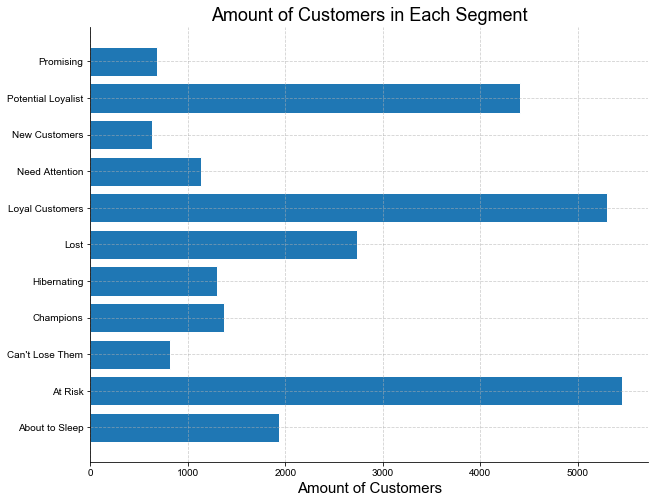

In [30]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot()
sns.set(style = "white", palette = "pastel")
plt.barh(range(len(customer_segment)),customer_segment.user_id)
plt.yticks(range(len(customer_segment)), labels = customer_segment.index)
plt.grid(linestyle = '--', alpha = 0.6)
plt.xlabel('Amount of Customers', fontsize =15)
plt.title('Amount of Customers in Each Segment', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig("6.3 Amount of Customer in each segment.png")

## RFM-using K-Means

In [31]:
rfm_km = rfm_data.iloc[:, [0,2,3,4]]
rfm_km

,user_id,gap,pur_freq,total_momentary
0,29025780,24,18,41.68
1,31229488,28,4,14.43
2,33535391,18,11,138.88
3,33609704,16,9,31.31
4,34080306,1,3,16.75
...,...,...,...,...
25757,566264460,0,6,9.74
25758,566270279,0,6,32.74
25759,566270544,0,1,19.84
25760,566272734,0,7,10.79


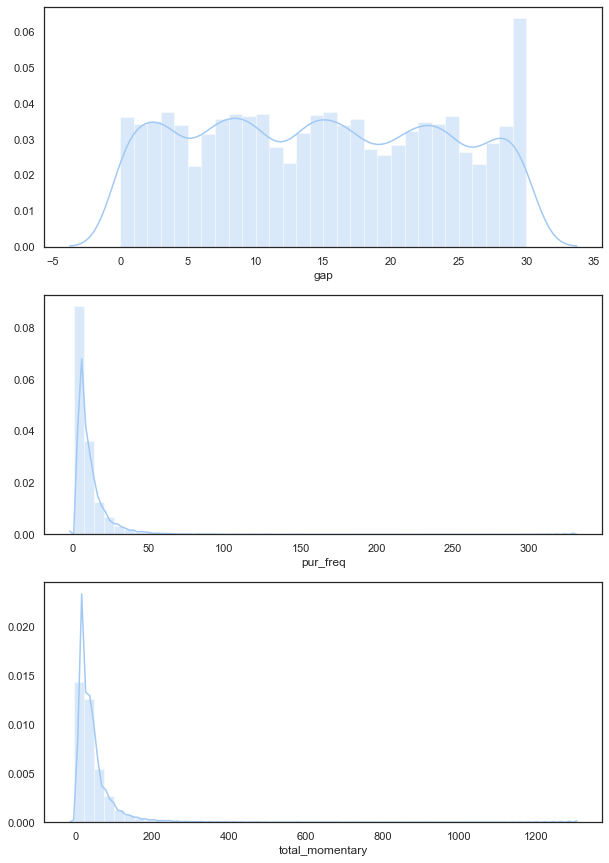

In [32]:
#查看RFM变量是否符合Kmeans算法的变量对称分布要求
figure, ax = plt.subplots(3,1,figsize=(10,15))
plt.subplot(3,1,1)
sns.distplot(rfm_km["gap"],label="Recency")
plt.subplot(3,1,2)
sns.distplot(rfm_km["pur_freq"],label="Frequency")
plt.subplot(3,1,3)
sns.distplot(rfm_km["total_momentary"], label="Monetary")

In [33]:
#使用对数变换解决对称性
X_train = rfm_km.iloc[:,1:4]
X_train.replace(0, 0.01)
X_train["pur_freq"]=rfm_km["pur_freq"].apply(np.log).round(3)
X_train["total_momentary"]=rfm_km["total_momentary"].apply(np.log).round(3)
X_train["total_momentary"].fillna(value=max(X_train["total_momentary"]),
                                  inplace=True)

In [34]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_train

array([[ 1.04132512,  1.12828525,  0.31482944],
       [ 1.4872741 , -0.40631741, -0.88696023],
       [ 0.37240167,  0.62627427,  1.67859453],
       ...,
       [-1.63436871, -1.82051907, -0.52563044],
       [-1.63436871,  0.16507719, -1.21544185],
       [-1.63436871, -1.82051907, -0.43048404]])

使用肘部法则选择聚类数目

In [35]:
from sklearn.cluster import KMeans
ks = range(1,9)
inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k,max_iter=300, n_init=10, init="k-means++",
                   random_state=0)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_) #样本距离其聚类中心的距离平方和
    print("k=",k,"iteration times: ", kmeans.n_iter_)

k= 1 iteration times:  2
k= 2 iteration times:  8
k= 3 iteration times:  8
k= 4 iteration times:  11
k= 5 iteration times:  15
k= 6 iteration times:  47
k= 7 iteration times:  23
k= 8 iteration times:  24


Text(0.5, 1.0, 'Elbow Criterion method to find best k')

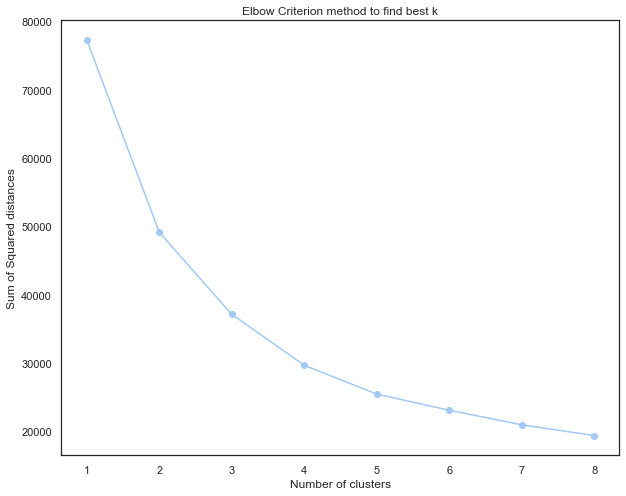

In [36]:
plt.figure(figsize=(10,8))
plt.plot(ks, inertias, "-o")
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared distances")
plt.title("Elbow Criterion method to find best k")

In [37]:
kmeans = KMeans(n_clusters=4,max_iter=300, n_init=10, init="k-means++",
                   random_state=0)
y_pred = kmeans.fit_predict(X_train)

In [38]:
#另一种获得预测分组的方式
cluster_label = kmeans.labels_
cluster_label

array([3, 0, 3, ..., 1, 1, 1])

In [39]:
rfm_km["group"] = y_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
rfm_km.group.value_counts()

1    7214
3    6761
0    6019
2    5768
Name: group, dtype: int64

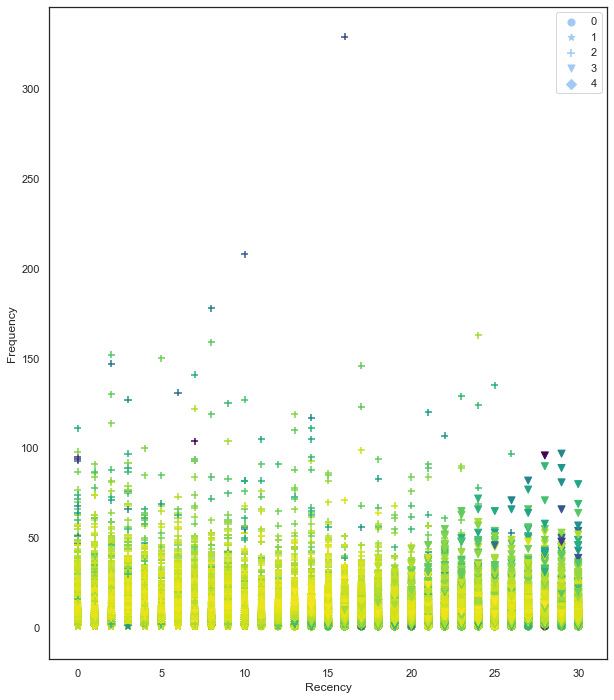

In [41]:
plt.figure(figsize=(10,12))
marker_li = ["o", "*", "+", "v","D"]
for i, m in zip(range(5), marker_li):
    data = rfm_km[rfm_km.group == i]
    x = data["gap"]
    y = data["pur_freq"]
    c = data["total_momentary"]
    plt.scatter(x=x,y=y,c=c,cmap="viridis_r",marker=m,s=50, label = i)
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.legend()

In [42]:
rfm_km.head()

,user_id,gap,pur_freq,total_momentary,group
0,29025780,24,18,41.68,3
1,31229488,28,4,14.43,0
2,33535391,18,11,138.88,3
3,33609704,16,9,31.31,3
4,34080306,1,3,16.75,1


In [43]:
rfm_km.groupby(["group"]).agg({"gap":"mean",
                              "pur_freq":"mean",
                              "total_momentary":["mean","count"]})

gap   pur_freq total_momentary      
            mean       mean            mean count
group                                            
0      22.433128   3.016282       18.137533  6019
1       6.971029   4.123094       23.301957  7214
2       7.281553  20.396845       95.383890  5768
3      22.237687  11.843810       56.810238  6761